## A simple simulation procedure for producing gradient-echo imaging k-space data

### 1. Loading julia packages

In [1]:
push!(LOAD_PATH,"library_Julia1");
using PyPlot
using Distributed
addprocs(Sys.CPU_THREADS-nprocs());
@show nprocs()
@everywhere using FFTW
@everywhere using LinearAlgebra
@everywhere using SharedArrays

nprocs() = 8


### 2. We will acquire 2D gradient-echo imaging data from a phantom, comprising 3 compartments:
![phantom](phantoms/phantom.jpg)


### We need to specify the following physical properties: 
* $T_2^*$ value for M1
* $T_2^*$ value for M2
* $T_2^*$ value for M3
* Frequency offset value (i.e., chemical shift: $\Delta \omega$ in Hz) for M2
* Frequency offset value (i.e., chemical shift: $\Delta \omega$ in Hz) for M3

In [2]:
T2valueForM1 = Float64(80e-3) # 80 msec
T2valueForM2 = Float64(40e-3) # 40 msec
T2valueForM3 = Float64(150e-3) # 150 msec
FrequencyOffsetForM2 = Float64(1200.) # Hz
FrequencyOffsetForM3 = Float64(-800.); # Hz

### 3. We also need to choose the following MRI scan parameters:
* Field of view (FOV) of imaging
* Dwell time (DW) of k-space data sampling
* Echo time (TE)
* Acquisition matrix size 
* Noise intensity (arbitrary unit)

**TR** is assumed to be significantly larger than T1 in this very simple simulation that does not consider T1 effect

In [3]:
FOV = Float64(250.) # in mm
DW = Float64(50e-6) # hard-coded for now
matrixSizeX = Int64(128) # should be integer: 32, 64, 96 or 128
matrixSizeY = Int64(128) # should be integer: 32, 64, 96 or 128
TE = Float64(50e-3) # 50 msec: The minimal value allowed is about 10 msec.
NoiseLevel = Float64(2000.); # arbitrary unit: between 0 and 100000: you can start with 2000

### 4. Constructing a phantom

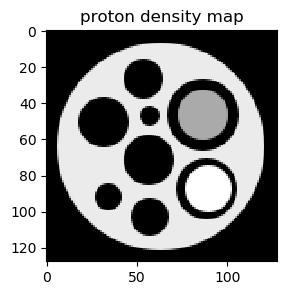

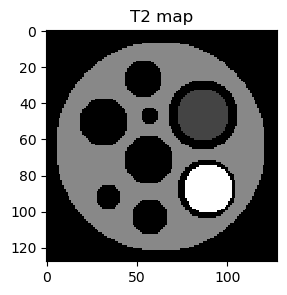

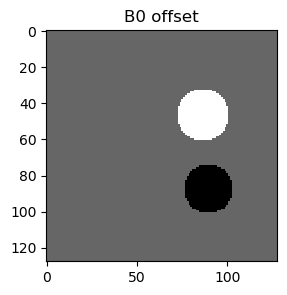

In [4]:
B0offsetForM2 = FrequencyOffsetForM2
B0offsetForM3 = FrequencyOffsetForM3
matrixSize = [matrixSizeX,matrixSizeY]

fid = open("phantoms/m1.img","r"); 
m1 = zeros(UInt8,128,128);
read!(fid,m1);
close(fid)
m1 = convert(Array{Float64},m1);
fid = open("phantoms/m2.img","r"); 
m2 = zeros(UInt8,128,128);
read!(fid,m2);
close(fid)
m2 = convert(Array{Float64},m2);
fid = open("phantoms/m3.img","r"); 
m3 = zeros(UInt8,128,128);
read!(fid,m3);
close(fid)
m3 = convert(Array{Float64},m3);
ProtonDensityMap = m1+m2+m3;

T2map = zeros(128,128);
T2map[findall(m1.>=2)].=T2valueForM1; T2map[findall(m2.>=2)].=T2valueForM2; T2map[findall(m3.>=3)].=T2valueForM3; 
B0offsetmap = zeros(128,128); B0offsetmap[findall(m2.>=2)].=B0offsetForM2; B0offsetmap[findall(m3.>=3)].=B0offsetForM3; 
PHANTOMSIZE = 240; # mm
xx = size(ProtonDensityMap)[1]; yy = size(ProtonDensityMap)[2];
vx = PHANTOMSIZE/xx; vy = PHANTOMSIZE/yy;
locationX = repeat(-vx*xx/2:vx:vx*xx/2-1,1,yy);
locationY = repeat((-vy*yy/2:vy:vy*yy/2-1)',xx,1);
figure(1,figsize=(3,3));imshow(ProtonDensityMap,cmap="gray", interpolation="none"); title("proton density map")
figure(2,figsize=(3,3));imshow(T2map,cmap="gray", interpolation="none"); title("T2 map")
figure(3,figsize=(3,3));imshow(B0offsetmap,cmap="gray", interpolation="none"); title("B0 offset");


### 5. Defining and calculating sequence parameters

In [5]:
d1 = 5e-3 # pre-phasing gradient duration
BW = 1/DW
ReadoutAcquisitionWindow = DW*matrixSize[1]
d2 = TE - (ReadoutAcquisitionWindow/2.)-d1
GradientX = BW/FOV   # Hz/mm
GradientYi = (GradientX*DW)/d1
GradientX1 = -GradientYi*(round(matrixSize[1]/2))
adcStartTime = d1+d2+DW
adcEndTime = d1+d2+ReadoutAcquisitionWindow;


### 6. Defining k data acqusition function

In [6]:
@everywhere function Kscan(t,kx,ky,pd,T2,B0,X,Y)
    kdata = zeros(Complex{Float64},size(t))
    i = complex(0,1)
    for cnt = 1:size(t)[1]
        kdata[cnt]=sum(pd.*exp.(-t[cnt]./T2).*exp.(i*2*π*B0*t[cnt]).*exp.(i*2*π*kx[cnt].*X).*exp.(i*2*π*ky[cnt].*Y))
    end
    return kdata
end

### 7. Computing k-space trajectories

In [7]:
kSpaceData2D = SharedArray{Complex{Float64,}}((matrixSize[1],matrixSize[2]))

timeSampled = 0:DW:adcEndTime
acquisition_timeSampled = timeSampled[1+size(DW:DW:d1)[1]+size(d1+DW:DW:d1+d2)[1]+1:end];

GxWaveform = vcat(0.,GradientX1*ones(size(DW:DW:d1)),zeros(size(d1+DW:DW:d1+d2)), GradientX*ones(size(adcStartTime:DW:adcEndTime)));
trajectory_kx = cumsum(GxWaveform)*DW;
acquisition_trajectory_kx = trajectory_kx[1+size(DW:DW:d1)[1]+size(d1+DW:DW:d1+d2)[1]+1:end];


### 8. k-space data acquisition

In [8]:
@time @sync @distributed for TRcount = 1:matrixSize[2]
    kyLocation = TRcount-round(matrixSize[2]/2)
    GyWaveform = vcat(0.,GradientYi*kyLocation.*ones(size(DW:DW:d1)),zeros(size(d1+DW:DW:d1+d2)), zeros(size(adcStartTime:DW:adcEndTime)));
    trajectory_ky = cumsum(GyWaveform)*DW;
    acquisition_trajectory_ky = trajectory_ky[1+size(DW:DW:d1)[1]+size(d1+DW:DW:d1+d2)[1]+1:end];
    kdata = Kscan(acquisition_timeSampled,acquisition_trajectory_kx,acquisition_trajectory_ky,ProtonDensityMap[:],T2map[:],B0offsetmap[:],locationX[:],locationY[:]);
    kSpaceData2D[:,TRcount] = kdata;
end

 10.894524 seconds (2.27 M allocations: 111.641 MiB, 0.34% gc time)


Task (done) @0x000000001283ee10

### 9. Optionally adding noise to the acquired k-space data; Reconstruction of imaging data

In [9]:
kSpaceData2D = kSpaceData2D + NoiseLevel*randn(size(kSpaceData2D)) + NoiseLevel*complex(0,1)*randn(size(kSpaceData2D));

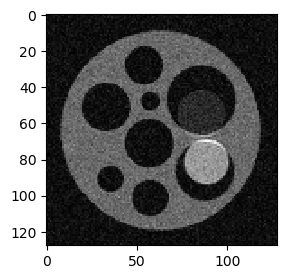

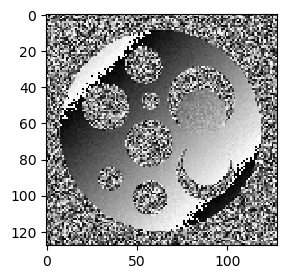

In [10]:
data1 = fftshift(fft(fftshift(kSpaceData2D)));
figure(1,figsize=(3,3));imshow(abs.(data1),cmap="gray", interpolation="none");
figure(2,figsize=(3,3));imshow(angle.(data1),cmap="gray", interpolation="none");

### 10. We could move the codes from sections 4 to 9 to a function 

In [11]:
@everywhere function MRIscan(T2valueForM1::Float64,T2valueForM2::Float64,T2valueForM3::Float64,FrequencyOffsetForM2::Float64,FrequencyOffsetForM3::Float64,FOV::Float64,DW::Float64,matrixSizeX::Int64,matrixSizeY::Int64,TE::Float64,NoiseLevel::Float64)
    B0offsetForM2 = FrequencyOffsetForM2
    B0offsetForM3 = FrequencyOffsetForM3
    matrixSize = [matrixSizeX,matrixSizeY]
    TE = max(TE,0.01)
    DW = 50e-6; # hard-coded for now
    #DW = min(DW, 100e-6)
    #DW = max(DW, 5e-6)
    matrixSizeX = max(matrixSizeX,32)
    matrixSizeX = min(matrixSizeX,128)
    matrixSizeY = max(matrixSizeX,32)
    matrixSizeY = min(matrixSizeX,128)
    fid = open("phantoms/m1.img","r"); 
    m1 = zeros(UInt8,128,128);
    read!(fid,m1);
    close(fid)
    m1 = convert(Array{Float64},m1);
    fid = open("phantoms/m2.img","r"); 
    m2 = zeros(UInt8,128,128);
    read!(fid,m2);
    close(fid)
    m2 = convert(Array{Float64},m2);
    fid = open("phantoms/m3.img","r"); 
    m3 = zeros(UInt8,128,128);
    read!(fid,m3);
    close(fid)
    m3 = convert(Array{Float64},m3);
    ProtonDensityMap = m1+m2+m3;
    T2map = zeros(128,128);
    T2map[findall(m1.>=2)].=T2valueForM1; T2map[findall(m2.>=2)].=T2valueForM2; T2map[findall(m3.>=3)].=T2valueForM3; 
    B0offsetmap = zeros(128,128); B0offsetmap[findall(m2.>=2)].=B0offsetForM2; B0offsetmap[findall(m3.>=3)].=B0offsetForM3; 
    PHANTOMSIZE = 240; # mm
    xx = size(ProtonDensityMap)[1]; yy = size(ProtonDensityMap)[2];
    vx = PHANTOMSIZE/xx; vy = PHANTOMSIZE/yy;
    locationX = repeat(-vx*xx/2:vx:vx*xx/2-1,1,yy);
    locationY = repeat((-vy*yy/2:vy:vy*yy/2-1)',xx,1);
    d1 = 5e-3 # pre-phasing gradient duration
    BW = 1/DW
    ReadoutAcquisitionWindow = DW*matrixSize[1]
    d2 = TE - (ReadoutAcquisitionWindow/2.)-d1
    GradientX = BW/FOV   # Hz/mm
    GradientYi = (GradientX*DW)/d1
    GradientX1 = -GradientYi*(round(matrixSize[1]/2))
    adcStartTime = d1+d2+DW
    adcEndTime = d1+d2+ReadoutAcquisitionWindow;

    kSpaceData2D = SharedArray{Complex{Float64,}}((matrixSize[1],matrixSize[2]))

    timeSampled = 0:DW:adcEndTime
    acquisition_timeSampled = timeSampled[1+size(DW:DW:d1)[1]+size(d1+DW:DW:d1+d2)[1]+1:end];

    GxWaveform = vcat(0.,GradientX1*ones(size(DW:DW:d1)),zeros(size(d1+DW:DW:d1+d2)), GradientX*ones(size(adcStartTime:DW:adcEndTime)));
    trajectory_kx = cumsum(GxWaveform)*DW;
    acquisition_trajectory_kx = trajectory_kx[1+size(DW:DW:d1)[1]+size(d1+DW:DW:d1+d2)[1]+1:end];

    @time @sync @distributed  for TRcount = 1:matrixSize[2]
        kyLocation = TRcount-round(matrixSize[2]/2)
        GyWaveform = vcat(0.,GradientYi*kyLocation.*ones(size(DW:DW:d1)),zeros(size(d1+DW:DW:d1+d2)), zeros(size(adcStartTime:DW:adcEndTime)));
        trajectory_ky = cumsum(GyWaveform)*DW;
        acquisition_trajectory_ky = trajectory_ky[1+size(DW:DW:d1)[1]+size(d1+DW:DW:d1+d2)[1]+1:end];
        kdata = Kscan(acquisition_timeSampled,acquisition_trajectory_kx,acquisition_trajectory_ky,ProtonDensityMap[:],T2map[:],B0offsetmap[:],locationX[:],locationY[:]);
        kSpaceData2D[:,TRcount] = kdata;
    end
    kSpaceData2D = kSpaceData2D + NoiseLevel*randn(size(kSpaceData2D)) + NoiseLevel*complex(0,1)*randn(size(kSpaceData2D))
    return kSpaceData2D
end


### 11. With the function defined in section 10, it would be easier to compute data sets corresponding to different TE values

  6.059394 seconds (231.71 k allocations: 11.637 MiB)
  6.586025 seconds (1.59 M allocations: 78.633 MiB, 0.46% gc time)


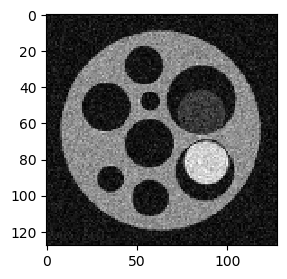

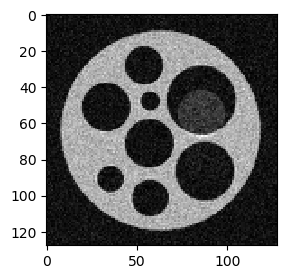

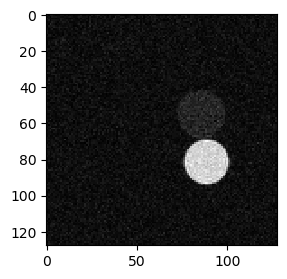

  5.550764 seconds (2.07 k allocations: 97.984 KiB)
  5.559573 seconds (3.17 k allocations: 2.508 MiB)


In [12]:
@time kSpaceData1 = MRIscan(T2valueForM1,T2valueForM2,T2valueForM3,FrequencyOffsetForM2,FrequencyOffsetForM3,FOV,DW,matrixSizeX,matrixSizeY,TE,NoiseLevel); 
data1 = fftshift(fft(fftshift(kSpaceData1)));
NewTE = TE + (0.5/FrequencyOffsetForM3);
@time kSpaceData2 = MRIscan(T2valueForM1,T2valueForM2,T2valueForM3,FrequencyOffsetForM2,FrequencyOffsetForM3,FOV,DW,matrixSizeX,matrixSizeY,NewTE,NoiseLevel);
data2 = fftshift(fft(fftshift(kSpaceData2)));
figure(1,figsize=(3,3));imshow(abs.(data2),cmap="gray", interpolation="none"); 
figure(2,figsize=(3,3));imshow(abs.(data1+data2)/2.,cmap="gray", interpolation="none"); 
figure(3,figsize=(3,3));imshow(abs.(data1-data2)/2.,cmap="gray", interpolation="none"); 

### Homework
* You may choose different phantom properties
* You may try different FOV, TE values, matrix size, noise level
* You may produce more images and average them to increase the signal to noise ratio
* You may produce multi-TE images for T2 mapping
* You may zero fill any part of the k-space and see the impact on reconstructed images (e.g., $k_y$ lines 1 to 30; or odd $k_y$ lines)
* You may look into __chemical shift effect__
* You may find a way to produce images with only signals from M2
